In [325]:
import os

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
import psycopg2
import pandas as pd
from psycopg2.extras import execute_values

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle

In [326]:
host = "localhost"  
port = "5432"
dbname = "loan_database"  
user = "myuser" 
password = "mypassword"  

In [327]:
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

cur = conn.cursor()

cur.execute("SELECT * FROM loan_data;")

results = cur.fetchall()

df = pd.DataFrame(results, columns=[
    "person_age", "person_gender", "person_education", "person_income",
    "person_emp_exp", "person_home_ownership", "loan_amnt", "loan_intent",
    "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", 
    "credit_score", "previous_loan_defaults_on_file", "loan_status"
])


In [328]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [329]:
df = df.dropna()

In [330]:
df["person_age"] = df["person_age"].astype(int)

In [331]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int32  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [333]:
df.dtypes

person_age                          int32
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [334]:
for col_name, dtype in df.dtypes.items():
    if dtype == "object":
        print(f"Column Name: {col_name} - Distinct values: {df[col_name].unique()}")


Column Name: person_gender - Distinct values: ['female' 'male']
Column Name: person_education - Distinct values: ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
Column Name: person_home_ownership - Distinct values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Column Name: loan_intent - Distinct values: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
Column Name: previous_loan_defaults_on_file - Distinct values: ['No' 'Yes']


In [335]:
def create_subplots(columns, col_type, num_col = 4):
    num_plots = len(columns)
    num_rows = (num_plots // num_col) + (num_plots % num_col > 0) 

    fig, axes = plt.subplots(num_rows, num_col, figsize=(num_col * 8, num_rows * 5))

    axes = axes.flatten()

    for i, col_name in enumerate(columns):
        if col_type=="number":
            sns.histplot(df[col_name], kde=True, bins=30, ax=axes[i])
            axes[i].set_title(col_name)
        if col_type == "category":
            df[col_name].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[i])
            axes[i].set_title(f"Pie Chart of {col_name}")
            axes[i].set_ylabel("")  # Remove default y-label


    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

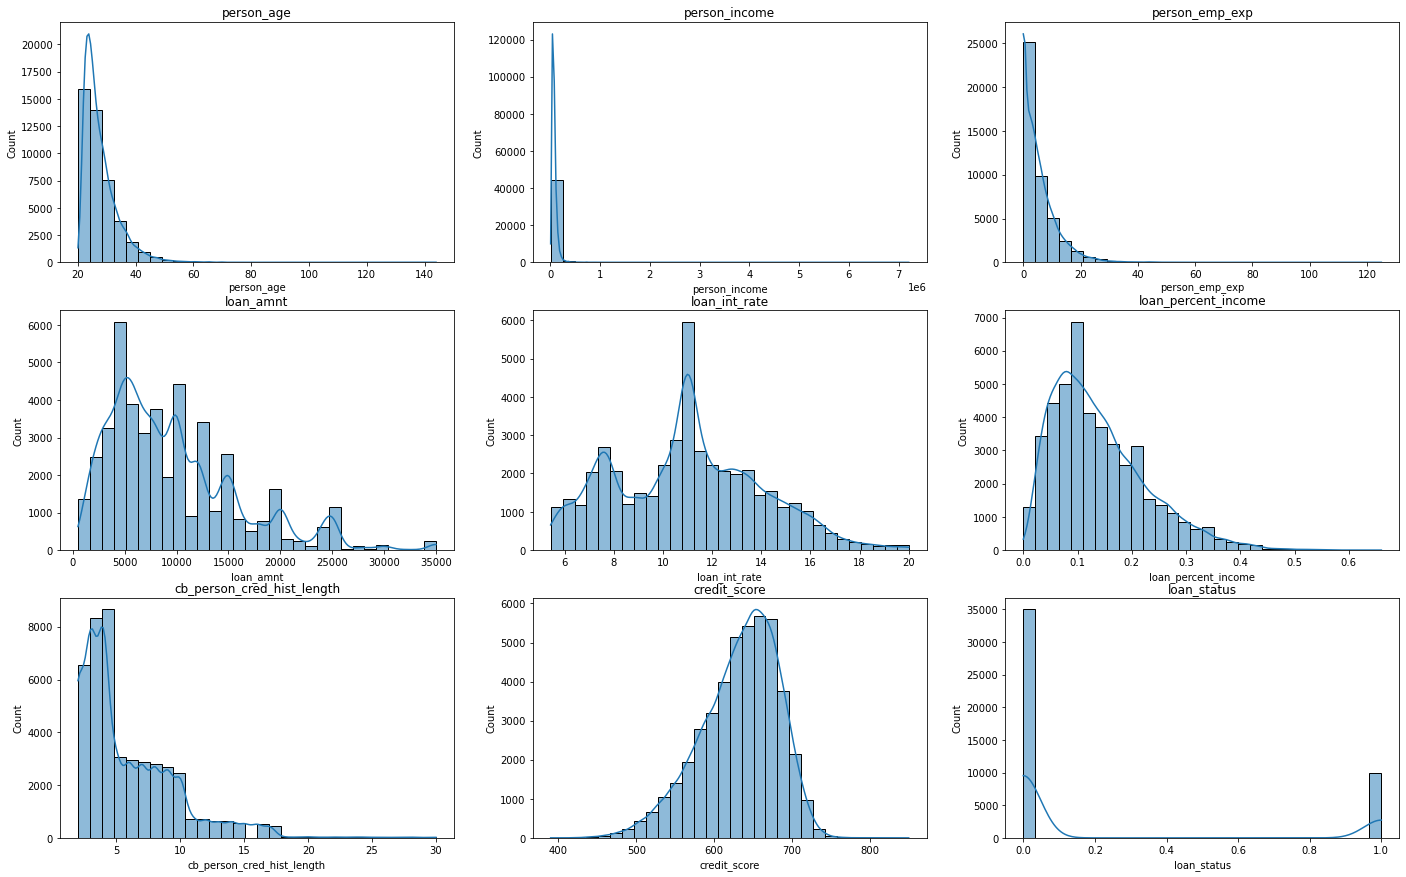

In [336]:
numeric_columns = df.select_dtypes(include=np.number).columns
create_subplots(columns = numeric_columns, col_type = "number", num_col = 3)

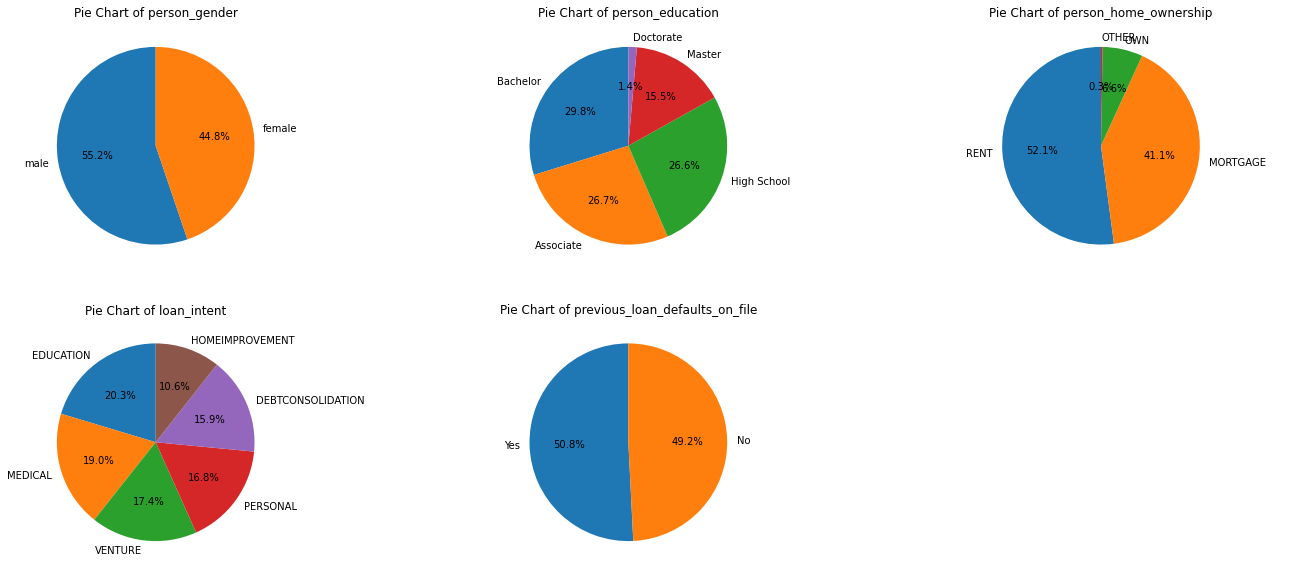

In [337]:
categorical_columns = df.select_dtypes(include=['object']).columns
create_subplots(columns = categorical_columns, col_type = "category", num_col = 3)

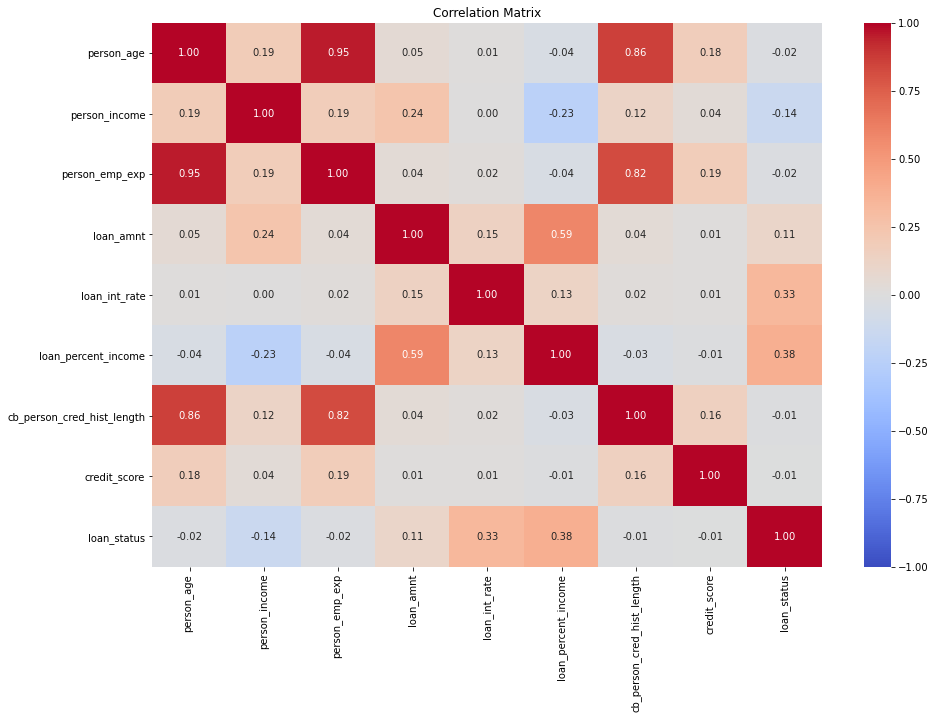

In [338]:
correlation_matrix = df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [339]:
df = df.drop(["person_age", "person_emp_exp"], axis=1)

In [340]:
numeric_columns = [col for col in numeric_columns if col not in ["person_age", "person_emp_exp"]]

In [341]:

X = df.drop('loan_status', axis=1)
y = df['loan_status']  

In [342]:
numeric_columns = [col for col in numeric_columns if col not in ["loan_status"]]

In [343]:
train_columns = X.columns.to_list()

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [345]:
column_list = df.columns.tolist()  
column_list_str = ', '.join(column_list)  

create_table_query = f"""
CREATE TABLE IF NOT EXISTS training_data (
    person_gender VARCHAR(50),
    person_education VARCHAR(50),
    person_income FLOAT,
    person_home_ownership VARCHAR(50),
    loan_amnt FLOAT,  
    loan_intent VARCHAR(50),
    loan_int_rate FLOAT,  
    loan_percent_income FLOAT,
    cb_person_cred_hist_length FLOAT,
    credit_score INT,
    previous_loan_defaults_on_file BOOLEAN,
    loan_status FLOAT,
    CONSTRAINT unique_training_columns UNIQUE (person_gender, person_education, person_income, person_home_ownership, 
        loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, 
        credit_score, previous_loan_defaults_on_file) 
);
"""
cur.execute(create_table_query)

train_data = X_train.copy() 
train_data['loan_status'] = y_train  

data_to_insert = train_data.values.tolist()

insert_query = f"""
    INSERT INTO training_data ({column_list_str})
    VALUES %s
    ON CONFLICT ON CONSTRAINT unique_training_columns 
    DO NOTHING; 
"""

execute_values(cur, insert_query, data_to_insert)

conn.commit()
cur.close()
conn.close()

In [346]:
test_data = X_test.copy()
test_data['loan_status'] = y_test
test_data.to_csv('../data/test_data.csv', index=False)

In [ ]:
scaler = RobustScaler(quantile_range=(20, 80))

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_train_categories = encoder.fit_transform(X_train[categorical_columns])
encoded_test_categories = encoder.transform(X_test[categorical_columns])

encoded_train_df = pd.DataFrame(encoded_train_categories, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test_categories, columns=encoder.get_feature_names_out(categorical_columns))

X_train_encoded = pd.concat([X_train[numeric_columns].reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=1)
X_test_encoded = pd.concat([X_test[numeric_columns].reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)

X_train_encoded = X_train_encoded.values
X_test_encoded = X_test_encoded.values

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_encoded shape: (36000, 20)
y_train shape: (36000,)
X_test_encoded shape: (9000, 20)
y_test shape: (9000,)


In [348]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np

In [349]:
z_scores = np.abs(zscore(X_train_encoded))

threshold = 3

mask = (z_scores < threshold).all(axis=1)  
X_train_encoded = X_train_encoded[mask]
y_train = y_train[mask]

In [350]:
def build_model():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(X_train_encoded.shape[1],)),  
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")  
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=build_model, epochs=10, batch_size=10, verbose=0)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(estimator, X_train_encoded, y_train, cv=stratified_kfold, n_jobs=2)
print(f"Cross-Validation Mean Accuracy: {cv_results.mean():.4f} ± {cv_results.std():.4f}")

In [ ]:
def calculate_psi(expected, observed, buckets=10):
    """
    Calculate PSI between two distributions.
    """
    expected_bins = pd.cut(expected, bins=buckets, include_lowest=True)
    observed_bins = pd.cut(observed, bins=expected_bins.categories, include_lowest=True)
    
    expected_counts = expected_bins.value_counts()
    observed_counts = observed_bins.value_counts()
    
    expected_pct = expected_counts / len(expected)
    observed_pct = observed_counts / len(observed)
    
    all_bins = expected_bins.categories
    expected_pct = expected_pct.reindex(all_bins, fill_value=0)
    observed_pct = observed_pct.reindex(all_bins, fill_value=0)

    psi_value = np.sum((observed_pct - expected_pct) * np.log(observed_pct / expected_pct))
    
    return psi_value

In [ ]:
def calculate_psi(train_data, test_data, bins=10):
    min_val = min(np.min(train_data), np.min(test_data))
    max_val = max(np.max(train_data), np.max(test_data))
    bin_edges = np.linspace(min_val, max_val, bins+1)

    train_counts, _ = np.histogram(train_data, bins=bin_edges)
    test_counts, _ = np.histogram(test_data, bins=bin_edges)

    train_proportions = train_counts / len(train_data)
    test_proportions = test_counts / len(test_data)

    epsilon = 1e-8
    psi = np.sum((train_proportions - test_proportions) * np.log((train_proportions + epsilon) / (test_proportions + epsilon)))
    
    return psi

In [354]:
def calculate_density_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    return mean, std_dev, skewness, kurtosis

In [ ]:
dist_analysis_dict = {}

for i in range(len(train_columns)):
    train_data = X_train_encoded[:, i]
    test_data = X_test_encoded[:, i]
    
    psi = calculate_psi(train_data, test_data)
    mean_train, std_dev_train, skewness_train, kurtosis_train = calculate_density_stats(train_data)
    mean_test, std_dev_test, skewness_test, kurtosis_test = calculate_density_stats(test_data)
    
    feature_key = f"{train_columns[i]}"
    dist_analysis_dict[feature_key] = {
        'PSI': psi,
        'Train_Mean': mean_train,
        'Train_Std_Dev': std_dev_train,
        'Train_Skewness': skewness_train,
        'Train_Kurtosis': kurtosis_train,
        'Test_Mean': mean_test,
        'Test_Std_Dev': std_dev_test,
        'Test_Skewness': skewness_test,
        'Test_Kurtosis': kurtosis_test
    }

print("\nPSI Values Between Training and Test Data:")
for feature, stats in dist_analysis_dict.items():
    psi = stats['PSI']
    message = "No significant shift" if psi < 0.1 else "Minor shift" if psi < 0.25 else "Significant shift"
    
    print(f"{feature}: PSI = {psi:.4f} -> {message}")
    print(f"  Train Stats -> Mean: {stats['Train_Mean']:.4f}, Std Dev: {stats['Train_Std_Dev']:.4f}, "
          f"Skewness: {stats['Train_Skewness']:.4f}, Kurtosis: {stats['Train_Kurtosis']:.4f}")
    print(f"  Test Stats  -> Mean: {stats['Test_Mean']:.4f}, Std Dev: {stats['Test_Std_Dev']:.4f}, "
          f"Skewness: {stats['Test_Skewness']:.4f}, Kurtosis: {stats['Test_Kurtosis']:.4f}")
    print("-" * 50)



PSI Values Between Training and Test Data:
person_gender: PSI = 0.0370 -> No significant shift
  Train Stats -> Mean: 0.1718, Std Dev: 0.7059, Skewness: 1.6746, Kurtosis: 4.1358
  Test Stats  -> Mean: 0.2095, Std Dev: 1.1142, Skewness: 11.4196, Kurtosis: 269.9970
--------------------------------------------------
person_education: PSI = 0.0845 -> No significant shift
  Train Stats -> Mean: 0.1233, Std Dev: 0.5627, Skewness: 0.9522, Kurtosis: 0.3960
  Test Stats  -> Mean: 0.1461, Std Dev: 0.6098, Skewness: 1.1728, Kurtosis: 1.3399
--------------------------------------------------
person_income: PSI = 0.0023 -> No significant shift
  Train Stats -> Mean: -0.0081, Std Dev: 0.5229, Skewness: 0.1738, Kurtosis: -0.4990
  Test Stats  -> Mean: 0.0041, Std Dev: 0.5345, Skewness: 0.2216, Kurtosis: -0.4149
--------------------------------------------------
person_home_ownership: PSI = 0.0627 -> No significant shift
  Train Stats -> Mean: 0.1001, Std Dev: 0.5359, Skewness: 0.8331, Kurtosis: 0.21

In [356]:
final_model = build_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
final_model.fit(X_train_encoded, y_train, epochs=20, batch_size=132, validation_split=0.2, callbacks=[reduce_lr])

y_train_pred_prob = final_model.predict(X_train_encoded)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)  

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nModel Evaluation on Training Set:")
print(f"Accuracy:  {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall:    {recall_train:.4f}")
print(f"F1-score:  {f1_train:.4f}")

Epoch 1/20
193/193 [==============================] - 1s 2ms/step - loss: 0.3092 - accuracy: 0.8659 - val_loss: 0.2264 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 2/20
193/193 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.9005 - val_loss: 0.2155 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 3/20
193/193 [==============================] - 0s 1ms/step - loss: 0.2081 - accuracy: 0.9064 - val_loss: 0.2090 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 4/20
193/193 [==============================] - 0s 1ms/step - loss: 0.2017 - accuracy: 0.9087 - val_loss: 0.2053 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 5/20
193/193 [==============================] - 0s 1ms/step - loss: 0.1986 - accuracy: 0.9100 - val_loss: 0.2030 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 6/20
193/193 [==============================] - 0s 1ms/step - loss: 0.1962 - accuracy: 0.9099 - val_loss: 0.2021 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 7/20
193/193 [==============================] - 0s 1ms/step - lo

In [357]:
if not os.path.exists("../fastapi/model/"):
    os.makedirs("../fastapi/model/")

In [358]:
with open('../fastapi/model/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

with open('../fastapi/model/encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

final_model.save("../fastapi/model/model.h5")

print("Model files are saved.")

Model files are saved.
